# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')
sys.path.append('../../')

In [3]:
import pandas as pd
from fairness.helpers import *
from fairness.avd_helpers import *
from sklearn import preprocessing
import torch
import torch.nn as nn
import torch.optim as optim
import time

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import aif360 as aif

from aif360.algorithms.inprocessing import AdversarialDebiasing
import tensorflow.compat.v1 as tf
from aif360.datasets import BinaryLabelDataset
from aif360.algorithms.preprocessing import LFR

#import skorch
#from skorch.net import NeuralNet as NN
import matplotlib.patches as mpatches


torch.manual_seed(1)
np.random.seed(7)
sns.set(style="white", palette="colorblind", color_codes=True, context="talk")
sns.set_theme()

tf.disable_eager_execution()

pip install 'aif360[LawSchoolGPA]'
2023-01-24 17:42:21.350380: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'


In [4]:
sns.set_palette('Set1')

# Loading Data

In [5]:
df = pd.read_csv('../../data/dutch/dutch.csv')

In [6]:
df.head()

,sex,age,household_position,household_size,prev_residence_place,citizenship,country_birth,edu_level,economic_status,cur_eco_activity,Marital_status,occupation
0,1,6,1131,112,1,1,1,5,111,135,1,2_1
1,2,10,1122,113,1,1,1,2,111,122,2,5_4_9
2,1,8,1122,113,1,1,1,2,111,122,2,2_1
3,1,12,1121,112,1,1,1,1,111,137,2,5_4_9
4,2,4,1110,114,1,1,1,2,111,138,1,5_4_9


In [7]:
df.columns = [c.strip() for c in df.columns]

In [8]:
data = df.assign(sex = df.sex.map({1: 'male', 2: 'female'}),
         occupation_high_level = df.occupation.map({'2_1': 1, '5_4_9': 0}),
         moved_recently = df.prev_residence_place.map({1:0, 2:1}),
         citizenship = df.citizenship.map({1: 'netherlands', 2: 'europe', 3: 'rest_of_world'}),
         country_birth = df.country_birth.map({1: 'netherlands', 2: 'europe', 3: 'rest_of_world'}),
         marital_status = df.Marital_status.map({1: 'single', 2: 'married', 3: 'widowed', 4: 'divorced'}),
         economic_status=df.economic_status.map({111: '111', 120: '120', 112: '112'}))\
    .drop(columns=['household_position', 'household_size', 'cur_eco_activity', 'occupation'])
data.head()

,sex,age,prev_residence_place,citizenship,country_birth,edu_level,economic_status,Marital_status,occupation_high_level,moved_recently,marital_status
0,male,6,1,netherlands,netherlands,5,111,1,1,0,single
1,female,10,1,netherlands,netherlands,2,111,2,0,0,married
2,male,8,1,netherlands,netherlands,2,111,2,1,0,married
3,male,12,1,netherlands,netherlands,1,111,2,0,0,married
4,female,4,1,netherlands,netherlands,2,111,1,0,0,single


## Split Data and Train Biased Model

In [9]:
(X_train, X_test, y_train, y_test, Z_train, Z_test) = split_scale_pipe(pd.get_dummies(data.drop(columns=['sex', 'occupation_high_level'])),
                                                                      data.occupation_high_level,
                                                                      (data.sex=='male').astype(int),
                                                                      stratify=data.occupation_high_level)

In [10]:
train_data = BinaryLabelDataset(df=X_train.assign(occupation_high_level = y_train, sex=Z_train), label_names=['occupation_high_level'], 
                                protected_attribute_names=['sex'])
test_data = BinaryLabelDataset(df=X_test.assign(occupation_high_level=y_test, sex=Z_test), label_names=['occupation_high_level'],
                               protected_attribute_names=['sex'])


tf.reset_default_graph()
sess = tf.Session()


privileged_groups = [{'sex': 1}]
unprivileged_groups = [{'sex': 0}]

biased_model = AdversarialDebiasing(unprivileged_groups=unprivileged_groups,
                 privileged_groups=privileged_groups,
                 scope_name='classifier',
                 debias=False,
                 sess=sess).fit(train_data)

dataset_nodebiasing_test = biased_model.predict(test_data)
acc = metrics.accuracy_score(y_test, dataset_nodebiasing_test.labels)
b_acc = metrics.balanced_accuracy_score(y_test, dataset_nodebiasing_test.labels)
prule = p_rule(dataset_nodebiasing_test.labels, Z_test)

2023-01-24 17:42:35.291323: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
2023-01-24 17:42:35.439144: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled


epoch 0; iter: 0; batch classifier loss: 0.761194
epoch 0; iter: 200; batch classifier loss: 0.403348
epoch 1; iter: 0; batch classifier loss: 0.443197
epoch 1; iter: 200; batch classifier loss: 0.396592
epoch 2; iter: 0; batch classifier loss: 0.473236
epoch 2; iter: 200; batch classifier loss: 0.463243
epoch 3; iter: 0; batch classifier loss: 0.433476
epoch 3; iter: 200; batch classifier loss: 0.377906
epoch 4; iter: 0; batch classifier loss: 0.456884
epoch 4; iter: 200; batch classifier loss: 0.388321
epoch 5; iter: 0; batch classifier loss: 0.374195
epoch 5; iter: 200; batch classifier loss: 0.445200
epoch 6; iter: 0; batch classifier loss: 0.329281
epoch 6; iter: 200; batch classifier loss: 0.367683
epoch 7; iter: 0; batch classifier loss: 0.322340
epoch 7; iter: 200; batch classifier loss: 0.348341
epoch 8; iter: 0; batch classifier loss: 0.311581
epoch 8; iter: 200; batch classifier loss: 0.406317
epoch 9; iter: 0; batch classifier loss: 0.360491
epoch 9; iter: 200; batch classi

In [11]:
print(f'accuracy = {acc * 100}%')
print(f'balanced accuracy = {b_acc * 100}%')
print(f'p-rule = {prule}%')

accuracy = 83.00562727573652%
balanced accuracy = 82.96204187925656%
p-rule = 45.64851989241833%


In [12]:
test_results = pd.DataFrame(Z_test).assign(biased_pred = dataset_nodebiasing_test.labels)

### LFR

In [13]:
lfr_accs = []
lfr_b_accs = []
lfr_prules = []
lfr_numch = []
lfr_changed = []

In [14]:
for i in range(10):
    privileged_groups = [{'sex': 1}]
    unprivileged_groups = [{'sex': 0}]

    train_bld = BinaryLabelDataset(df=X_train.assign(occupation_high_level = y_train, sex=Z_train),
                                  label_names=['occupation_high_level'],
                                  protected_attribute_names=['sex'])

    test_bld =  BinaryLabelDataset(df=X_test.assign(occupation_high_level = y_test, sex=Z_test),
                                  label_names=['occupation_high_level'],
                                  protected_attribute_names=['sex'])

    start = time.time()
    lfr = LFR(
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups,
        Az=8
             ).fit(train_bld)

    new_train_data = lfr.transform(train_bld)
    new_test_data = lfr.transform(test_bld)

    tf.reset_default_graph()
    sess = tf.Session()


    privileged_groups = [{'sex': 1}]
    unprivileged_groups = [{'sex': 0}]

    model = AdversarialDebiasing(unprivileged_groups=unprivileged_groups,
                     privileged_groups=privileged_groups,
                     scope_name='classifier',
                     debias=False,
                     sess=sess).fit(new_train_data)

    dataset_nodebiasing_test = model.predict(new_test_data)
    acc = metrics.accuracy_score(y_test, dataset_nodebiasing_test.labels)
    b_acc = metrics.balanced_accuracy_score(y_test, dataset_nodebiasing_test.labels)
    prule = p_rule(dataset_nodebiasing_test.labels, Z_test)

    print(f'accuracy = {acc * 100}%')
    print(f'balanced accuracy = {b_acc * 100}%')
    print(f'p-rule = {prule}%')
    
    lfr_accs.append(acc)
    lfr_b_accs.append(b_acc)
    lfr_prules.append(prule)
    
    t = test_results.assign(lfr_pred = dataset_nodebiasing_test.labels)
    t = t.assign(lfr_change = t.lfr_pred - t.biased_pred)
    changed = t[t.lfr_change!=0]
    
    num_changed = len(changed)
    lfr_changed.append(changed)
    lfr_numch.append(num_changed)

epoch 0; iter: 0; batch classifier loss: 0.836795
epoch 0; iter: 200; batch classifier loss: 0.088764
epoch 1; iter: 0; batch classifier loss: 0.078043
epoch 1; iter: 200; batch classifier loss: 0.061212
epoch 2; iter: 0; batch classifier loss: 0.054752
epoch 2; iter: 200; batch classifier loss: 0.069888
epoch 3; iter: 0; batch classifier loss: 0.054460
epoch 3; iter: 200; batch classifier loss: 0.047107
epoch 4; iter: 0; batch classifier loss: 0.078947
epoch 4; iter: 200; batch classifier loss: 0.075377
epoch 5; iter: 0; batch classifier loss: 0.053373
epoch 5; iter: 200; batch classifier loss: 0.032771
epoch 6; iter: 0; batch classifier loss: 0.048712
epoch 6; iter: 200; batch classifier loss: 0.027037
epoch 7; iter: 0; batch classifier loss: 0.051880
epoch 7; iter: 200; batch classifier loss: 0.028208
epoch 8; iter: 0; batch classifier loss: 0.024256
epoch 8; iter: 200; batch classifier loss: 0.025936
epoch 9; iter: 0; batch classifier loss: 0.033859
epoch 9; iter: 200; batch classi

In [22]:
lfr_stats

,Run,Accuracy,Balanced Accuracy,P%-rule,% of predictions changed,num of predictions changed
0,1,0.751672,0.748985,98.491631,20.357498,6150
1,2,0.779643,0.772884,76.269115,15.998014,4833
2,3,0.754684,0.752737,93.752337,20.182059,6097
3,4,0.755842,0.749810,98.934705,19.589540,5918
4,5,0.737471,0.741744,95.053563,17.586892,5313
5,6,0.526581,0.502944,59.715877,47.255876,14276
6,7,0.708342,0.696702,85.525817,25.809335,7797
7,8,0.777160,0.772712,88.185075,16.630255,5024
8,9,0.727441,0.729282,86.054723,22.899702,6918
9,10,0.783317,0.778906,86.548908,15.948361,4818


In [ ]:
inters = set(lfr_changed[0].index)
for i in [0,2,3,4,6,7,8]:
    inters = inters.intersection(set(lfr_changed[i].index))

NameError: name 'lfr_changed' is not defined

In [24]:
lfr_inters = inters
len(lfr_inters) / len(X_test) * 100

4.8262164846077455

In [25]:
test_results.loc[list(inters)].groupby('sex').describe()

biased_pred                                             
          count      mean       std  min  25%  50%  75%  max
sex                                                         
0         436.0  0.011468  0.106595  0.0  0.0  0.0  0.0  1.0
1        1022.0  1.000000  0.000000  1.0  1.0  1.0  1.0  1.0

In [26]:
lfr_stats = pd.DataFrame({
    'Run': range(1,11),
    'Accuracy':lfr_accs,
    'Balanced Accuracy': lfr_b_accs,
    'P%-rule': lfr_prules,
    '% of predictions changed': [l/len(X_test)*100 for l in lfr_numch],
    'num of predictions changed': lfr_numch
})

In [27]:
lfr_stats[lfr_stats['P%-rule']>80].describe()

,Run,Accuracy,Balanced Accuracy,P%-rule,% of predictions changed,num of predictions changed
count,8.000000,8.000000,8.000000,8.000000,8.000000,8.00000
mean,5.875000,0.749491,0.746360,91.568345,19.875455,6004.37500
std,3.136764,0.024801,0.025613,5.639974,3.294064,995.13688
min,1.000000,0.708342,0.696702,85.525817,15.948361,4818.00000
25%,3.750000,0.734964,0.738628,86.425361,17.347733,5240.75000
50%,6.000000,0.753178,0.749397,90.968706,19.885799,6007.50000
75%,8.250000,0.761172,0.757731,95.913080,20.993049,6342.00000
max,10.000000,0.783317,0.778906,98.934705,25.809335,7797.00000


In [28]:
lfr_stats[lfr_stats['P%-rule']>80].to_csv('../../results/dutch/runs/lfr_stats.csv')

### Advesarial Debiasing

In [29]:
import fairlearn_int
import fairness.avd_helpers as avh
from fairlearn_int.adversarial import AdversarialFairnessClassifier

In [30]:
adv_accs = []
adv_b_accs = []
adv_prules = []
adv_numch = []
adv_changed = []

In [31]:
for i in range(10):
    torch.manual_seed(i*100)
    adfl = AdversarialFairnessClassifier(predictor_model=[200, nn.ReLU()], 
                                        adversary_model=avh.Adversary_old(), #[200, nn.ReLU()],
                                        alpha=10.86, epochs = 10, random_state=i)
    adfl_ = adfl.fit(X=X_train, y=y_train, sensitive_features=Z_train)

    preds = adfl_.predict(X_test)
    preds.index=X_test.index
    acc = metrics.accuracy_score(y_test, preds) * 100
    b_acc = metrics.balanced_accuracy_score(y_test, preds) * 100
    prule = p_rule(preds, Z_test.values)

    print(f'run {i}')
    print(f'accuracy = {acc:.2f}%')
    print(f'balanced accuracy = {b_acc:.2f}%')
    print(f'p-rule = {prule:.2f}%')

    adv_accs.append(acc)
    adv_b_accs.append(b_acc)
    adv_prules.append(prule)
    
    t = test_results.assign(pred = preds)
    t = t.assign(change = t.pred - t.biased_pred)
    changed = t[t.change!=0]
    
    num_changed = len(changed)
    adv_numch.append(num_changed)
    adv_changed.append(changed)
    
    print(num_changed)

run 0
accuracy = 75.13%
balanced accuracy = 74.94%
p-rule = 87.99%
5536
run 1
accuracy = 71.40%
balanced accuracy = 71.74%
p-rule = 92.97%
7008
run 2
accuracy = 75.04%
balanced accuracy = 75.17%
p-rule = 88.20%
5420
run 3
accuracy = 73.58%
balanced accuracy = 73.73%
p-rule = 89.66%
5446
run 4
accuracy = 72.28%
balanced accuracy = 71.88%
p-rule = 92.16%
6542
run 5
accuracy = 73.60%
balanced accuracy = 73.20%
p-rule = 88.39%
5978
run 6
accuracy = 72.61%
balanced accuracy = 72.29%
p-rule = 90.96%
6417
run 7
accuracy = 74.22%
balanced accuracy = 74.21%
p-rule = 88.31%
5674
run 8
accuracy = 74.50%
balanced accuracy = 74.48%
p-rule = 88.17%
5516
run 9
accuracy = 74.42%
balanced accuracy = 74.39%
p-rule = 88.16%
5461


In [32]:
adv_stats = pd.DataFrame({
    'Run': range(1,11),
    'Accuracy':adv_accs,
    'Balanced Accuracy': adv_b_accs,
    'P%-rule': adv_prules,
    'Number of instances changed': adv_numch,
    '% of predictions changed': [l/len(X_test)*100 for l in adv_numch]
})

In [33]:
adv_stats.describe()

,Run,Accuracy,Balanced Accuracy,P%-rule,Number of instances changed,% of predictions changed
count,10.00000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,5.50000,73.677590,73.601839,89.498214,5899.800000,19.529295
std,3.02765,1.236992,1.263639,1.867970,565.043322,1.870385
min,1.00000,71.400199,71.739220,87.994071,5420.000000,17.941079
25%,3.25000,72.852532,72.512778,88.179978,5474.750000,18.122310
50%,5.50000,73.909302,73.969648,88.351349,5605.000000,18.553459
75%,7.75000,74.477822,74.454396,90.633642,6307.250000,20.878021
max,10.00000,75.127441,75.171873,92.967281,7008.000000,23.197617


In [34]:
adv_stats

,Run,Accuracy,Balanced Accuracy,P%-rule,Number of instances changed,% of predictions changed
0,1,75.127441,74.942947,87.994071,5536,18.325058
1,2,71.400199,71.739220,92.967281,7008,23.197617
2,3,75.041377,75.171873,88.204177,5420,17.941079
3,4,73.584906,73.727314,89.661935,5446,18.027143
4,5,72.280702,71.879103,92.161736,6542,21.655081
5,6,73.598146,73.196083,88.391459,5978,19.788150
6,7,72.608408,72.285009,90.957544,6417,21.241311
7,8,74.220457,74.211983,88.311239,5674,18.781860
8,9,74.498510,74.476364,88.171911,5516,18.258855
9,10,74.415756,74.388490,88.160792,5461,18.076796


In [35]:
inters = set(adv_changed[0].index)
for i in range(len(adv_changed)):
    inters = inters.intersection(set(adv_changed[i].index))

In [38]:
adv_inters = inters
len(adv_inters) / len(X_test) * 100

9.71201588877855

In [39]:
len(adv_inters)

2934

In [40]:
test_results.loc[list(inters)].groupby('sex').describe()

biased_pred                                             
          count      mean       std  min  25%  50%  75%  max
sex                                                         
0        1331.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0
1        1603.0  0.893949  0.307999  0.0  1.0  1.0  1.0  1.0

In [31]:
adv_stats.to_csv('../../results/dutch/runs/adv_dp_stats.csv')

In [32]:
test_results = test_results.assign(adv_pred = preds)

### Advesarial Debiasing (Equal Odds)

In [41]:
import fairlearn_int
import fairness.avd_helpers as avh
from fairlearn_int.adversarial import AdversarialFairnessClassifier

In [42]:
adv_eo_accs = []
adv_eo_b_accs = []
adv_eo_prules = []
adv_eo_eqd = []
adv_eo_eqr = []
adv_eo_numch = []
adv_eo_changed = []

In [43]:
for i in range(10):
    torch.manual_seed(i*1000)

    adfl = AdversarialFairnessClassifier(predictor_model=[200, nn.ReLU()], 
                                        adversary_model=avh.Adversary_old(n_input = 2, n_hidden=128),
                                        #adversary_model=[128, nn.ReLU(), 128, nn.ReLU(), 128, nn.ReLU()],
                                        constraints='equalized_odds', epochs=10,
                                        alpha=130, random_state=i*100, shuffle=True)
    
    adfl_ = adfl.fit(X=X_train, y=y_train, sensitive_features=Z_train)
    preds = adfl_.predict(X_test)
    preds.index=X_test.index
    acc = metrics.accuracy_score(y_test, preds) * 100
    b_acc = metrics.balanced_accuracy_score(y_test, preds) * 100
    prule = p_rule(preds, Z_test.values)
    eq_odds_ratio = equalized_odds_ratio(y_true=y_test, y_pred=preds, 
                                                         sensitive_features=Z_test)
    eq_odds_diff = equalized_odds_difference(y_true=y_test, y_pred=preds, 
                                                         sensitive_features=Z_test)


    adv_eo_accs.append(acc)
    adv_eo_b_accs.append(b_acc)
    adv_eo_prules.append(prule)
    adv_eo_eqd.append(eq_odds_diff)
    adv_eo_eqr.append(eq_odds_ratio)
    
    t = test_results.assign(pred = preds)
    t = t.assign(change = t.pred - t.biased_pred)
    changed = t[t.change!=0]
    
    num_changed = len(changed)
    adv_eo_numch.append(num_changed)
    adv_eo_changed.append(changed)
    
    print(f'run {i}')
    print(f'accuracy = {acc:.2f}%')
    print(f'balanced accuracy = {b_acc:.2f}%')
    print(f'p-rule = {prule:.2f}%')
    print(f'Equalized Odds ratio = {eq_odds_ratio:.2f}')
    print(f'Equalized Odds difference = {eq_odds_diff:.2f}')
    print(f'Number of predictions changed = {num_changed}')
    print()

run 0
accuracy = 80.48%
balanced accuracy = 80.07%
p-rule = 70.94%
Equalized Odds ratio = 0.87
Equalized Odds difference = 0.10
Number of predictions changed = 3686

run 1
accuracy = 80.98%
balanced accuracy = 80.55%
p-rule = 70.70%
Equalized Odds ratio = 0.86
Equalized Odds difference = 0.11
Number of predictions changed = 3437

run 2
accuracy = 80.24%
balanced accuracy = 79.92%
p-rule = 74.93%
Equalized Odds ratio = 0.86
Equalized Odds difference = 0.11
Number of predictions changed = 3840

run 3
accuracy = 80.61%
balanced accuracy = 80.12%
p-rule = 69.20%
Equalized Odds ratio = 0.89
Equalized Odds difference = 0.09
Number of predictions changed = 3653

run 4
accuracy = 80.46%
balanced accuracy = 79.95%
p-rule = 68.51%
Equalized Odds ratio = 0.89
Equalized Odds difference = 0.08
Number of predictions changed = 3729

run 5
accuracy = 79.55%
balanced accuracy = 79.03%
p-rule = 68.23%
Equalized Odds ratio = 0.90
Equalized Odds difference = 0.07
Number of predictions changed = 4071

run 

In [44]:
adv_eo_stats = pd.DataFrame({
    'Run': range(1,11),
    'Accuracy':adv_eo_accs,
    'Balanced Accuracy': adv_eo_b_accs,
    'P%-rule': adv_eo_prules,
    'Number of instances changed': adv_eo_numch,
    '% of predictions changed': [l/len(X_test)*100 for l in adv_eo_numch]
})

In [45]:
adv_eo_stats.describe()

,Run,Accuracy,Balanced Accuracy,P%-rule,Number of instances changed,% of predictions changed
count,10.00000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,5.50000,80.160543,79.767691,70.878491,3712.700000,12.289639
std,3.02765,0.949362,0.818646,2.535917,235.753661,0.780383
min,1.00000,77.841774,77.978083,68.206933,3437.000000,11.377027
25%,3.25000,79.818769,79.327305,68.685334,3525.500000,11.669977
50%,5.50000,80.468388,80.009391,70.634020,3680.000000,12.181397
75%,7.75000,80.744786,80.335405,72.241049,3812.250000,12.619166
max,10.00000,80.983118,80.549283,74.930993,4103.000000,13.581595


In [46]:
adv_eo_stats

,Run,Accuracy,Balanced Accuracy,P%-rule,Number of instances changed,% of predictions changed
0,1,80.476663,80.067858,70.944621,3686,12.201258
1,2,80.976498,80.549283,70.703609,3437,11.377027
2,3,80.238332,79.918985,74.930993,3840,12.711023
3,4,80.605760,80.117580,69.203128,3653,12.092023
4,5,80.460113,79.950924,68.512736,3729,12.343595
5,6,79.553128,79.025630,68.226437,4071,13.475670
6,7,77.841774,77.978083,74.818836,3674,12.161536
7,8,80.791129,80.408014,72.673192,3451,11.423370
8,9,79.678914,79.130079,68.206933,4103,13.581595
9,10,80.983118,80.530474,70.564430,3483,11.529295


In [40]:
adv_eo_stats.to_csv('../../results/dutch/runs/adv_eo_stats.csv')

In [47]:
inters = set(adv_eo_changed[0].index)
for i in range(len(adv_eo_changed)):
    inters = inters.intersection(set(adv_eo_changed[i].index))

In [49]:
adv_eo_inters = inters
len(adv_eo_inters) / len(X_test) * 100

4.197285666997683

### Equal Odds

In [50]:
import fairlearn_int
from fairlearn_int.postprocessing import ThresholdOptimizer as TOp

In [51]:
bld_train = BinaryLabelDataset(df=X_train.join(y_train).join(Z_train), label_names=['occupation_high_level'], protected_attribute_names=['sex'])

In [52]:
eo_accs = []
eo_b_accs = []
eo_prules = []
eo_rs = []
eo_ds = []
eo_numch = []
eo_changed = []

In [53]:
for i in range(10):
    m = TOp(estimator=biased_model, constraints='equalized_odds',
            predict_method='predict', prefit=True).fit(X=torch.Tensor(X_train.assign(sex=Z_train).set_index('sex').to_numpy()),
                                                                               y=torch.Tensor(y_train.to_numpy()),
                                                                               sensitive_features=torch.Tensor(Z_train.to_numpy()),
                                                                               Z=Z_train, 
                                                                               bld=bld_train)

    preds = m.predict(X=X_test,
                      sensitive_features=torch.Tensor(Z_test.to_numpy()),
                      y=y_test,
                      Z=Z_test,
                      bld=test_data
                     )

    acc = metrics.accuracy_score(y_test, preds) * 100
    b_acc = metrics.balanced_accuracy_score(y_test, preds) * 100
    prule = p_rule(preds, Z_test)
    eq_odds_ratio = equalized_odds_ratio(y_true=y_test, y_pred=preds, 
                                                         sensitive_features=Z_test)
    eq_odds_diff = equalized_odds_difference(y_true=y_test, y_pred=preds, 
                                                         sensitive_features=Z_test)

    t = test_results.assign(pred = preds)
    t = t.assign(change = t.pred - t.biased_pred)
    changed = t[t.change!=0]

    num_changed = len(changed)
    eo_numch.append(num_changed)
    eo_changed.append(changed)
    eo_accs.append(acc)
    eo_b_accs.append(b_acc)
    eo_prules.append(prule)
    eo_rs.append(eq_odds_ratio)
    eo_ds.append(eq_odds_diff)

    print(f'run {i}:')
    print(f'accuracy = {acc:2f}%')
    print(f'balanced accuracy = {b_acc:.2f}%')
    print(f'p-rule = {prule:.2f}%')
    print(f'Equalized Odds ratio = {eq_odds_ratio:.2f}')
    print(f'Equalized Odds difference = {eq_odds_diff:.2f}')
    print(f'Number of instances changed: {num_changed}')
    print()

run 0:
accuracy = 79.659053%
balanced accuracy = 79.16%
p-rule = 63.83%
Equalized Odds ratio = 0.97
Equalized Odds difference = 0.01
Number of instances changed: 3999

run 1:
accuracy = 79.635882%
balanced accuracy = 79.14%
p-rule = 63.44%
Equalized Odds ratio = 0.95
Equalized Odds difference = 0.01
Number of instances changed: 4018

run 2:
accuracy = 79.553128%
balanced accuracy = 79.05%
p-rule = 63.77%
Equalized Odds ratio = 0.98
Equalized Odds difference = 0.01
Number of instances changed: 4015

run 3:
accuracy = 79.536577%
balanced accuracy = 79.03%
p-rule = 63.22%
Equalized Odds ratio = 0.96
Equalized Odds difference = 0.00
Number of instances changed: 4040

run 4:
accuracy = 79.377690%
balanced accuracy = 78.87%
p-rule = 63.29%
Equalized Odds ratio = 0.99
Equalized Odds difference = 0.00
Number of instances changed: 4082

run 5:
accuracy = 79.496855%
balanced accuracy = 79.00%
p-rule = 64.02%
Equalized Odds ratio = 0.99
Equalized Odds difference = 0.01
Number of instances changed

In [54]:
eo_stats = pd.DataFrame({
    'Run': range(1,11),
    'Accuracy':eo_accs,
    'Balanced Accuracy': eo_b_accs,
    'P%-rule': eo_prules,
    'Equal Odds Ratio': eo_rs,
    'Equal Odds Difference': eo_ds,
    'Number of instances changed': eo_numch,
    '% of predictions changed': [l/len(X_test)*100 for l in eo_numch]
})

In [18]:
eo_stats.to_csv('../../results/dutch/runs/eo_stats.csv')

In [55]:
eo_stats.describe()

,Run,Accuracy,Balanced Accuracy,P%-rule,Equal Odds Ratio,Equal Odds Difference,Number of instances changed,% of predictions changed
count,10.00000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,5.50000,79.523999,79.022546,63.438382,0.970694,0.004830,4030.400000,13.341278
std,3.02765,0.091105,0.093773,0.382584,0.013460,0.001682,30.689122,0.101586
min,1.00000,79.377690,78.872846,62.707535,0.954181,0.002078,3976.000000,13.161205
25%,3.25000,79.485270,78.983934,63.235197,0.960060,0.004010,4015.750000,13.292784
50%,5.50000,79.516716,79.017441,63.433455,0.966339,0.004756,4034.000000,13.353194
75%,7.75000,79.585402,79.084655,63.717785,0.980488,0.005425,4040.000000,13.373055
max,10.00000,79.659053,79.162968,64.018123,0.992458,0.008189,4082.000000,13.512082


In [56]:
inters = set(eo_changed[0].index)
for i in range(len(eo_changed)):
    inters = inters.intersection(set(eo_changed[i].index))

In [58]:
eo_inters = inters
len(eo_inters )/ len(X_test) * 100

9.635882158225753

### Reject Option Classification

In [22]:
from fairness.avd_helpers import RejectOptionClassifier

In [23]:
scores = biased_model.predict(test_data).scores.flatten()
labels = biased_model.predict(test_data).labels.flatten()

preds = RejectOptionClassifier(0.92).predict(scores, Z_test.values)

In [24]:
print(metrics.accuracy_score(y_test, labels)*100)
print(metrics.balanced_accuracy_score(y_test, labels)*100)
print(p_rule(scores, Z_test))

print('-------------')
print('debiased:')

print(metrics.accuracy_score(y_test, preds)*100)
print(metrics.balanced_accuracy_score(y_test, preds)*100)
print(p_rule(preds, Z_test))

83.00562727573652
82.96204187925656
45.64851989241833
-------------
debiased:
76.20986428334989
75.32226801294372
96.90593315381241


In [25]:
acc = metrics.accuracy_score(y_test, preds)*100
b_acc = metrics.balanced_accuracy_score(y_test, preds)*100
prule = p_rule(preds, Z_test)

In [26]:
t = test_results.assign(pred = preds)
t = t.assign(change = t.pred - t.biased_pred)
num_changed = len(t[t.change!=0])

In [27]:
roc_stats = pd.DataFrame({
    'Run': range(1,11),
    'Accuracy':acc,
    'Balanced Accuracy': b_acc,
    'P%-rule': prule,
    'Number of instances changed': num_changed,
    '% of predictions changed': num_changed/len(X_test)*100
})

In [28]:
roc_stats

,Run,Accuracy,Balanced Accuracy,P%-rule,Number of instances changed,% of predictions changed
0,1,76.209864,75.322268,96.905933,5209,17.242635
1,2,76.209864,75.322268,96.905933,5209,17.242635
2,3,76.209864,75.322268,96.905933,5209,17.242635
3,4,76.209864,75.322268,96.905933,5209,17.242635
4,5,76.209864,75.322268,96.905933,5209,17.242635
5,6,76.209864,75.322268,96.905933,5209,17.242635
6,7,76.209864,75.322268,96.905933,5209,17.242635
7,8,76.209864,75.322268,96.905933,5209,17.242635
8,9,76.209864,75.322268,96.905933,5209,17.242635
9,10,76.209864,75.322268,96.905933,5209,17.242635


In [29]:
roc_stats.to_csv('../../results/dutch/runs/roc_stats.csv')

# Plots

In [33]:
lfr_stats = pd.read_csv('../../results/dutch/runs/lfr_stats.csv')
adv_stats = pd.read_csv('../../results/dutch/runs/adv_dp_stats.csv')
adv_eo_stats = pd.read_csv('../../results/dutch/runs/adv_eo_stats.csv')
eo_stats = pd.read_csv('../../results/dutch/runs/eo_stats.csv')
roc_stats = pd.read_csv('../../results/dutch/runs/roc_stats.csv')

In [32]:
lfr_inters = set(lfr_changed[0].index)
for i in range(len(lfr_changed)):
    lfr_inters = lfr_inters.intersection(set(lfr_changed[i].index))
    
adv_inters = set(adv_changed[0].index)
for i in range(len(adv_changed)):
    adv_inters = adv_inters.intersection(set(adv_changed[i].index))
    
adv_eo_inters = set(adv_eo_changed[0].index)
for i in range(len(adv_eo_changed)):
    adv_eo_inters = adv_eo_inters.intersection(set(adv_eo_changed[i].index))
    
eo_inters = set(eo_changed[0].index)
for i in range(len(eo_changed)):
    eo_inters = eo_inters.intersection(set(eo_changed[i].index))
    
roc_inters = t[t.change!=0].index

lfr_inters = len(lfr_inters)
adv_inters = len(adv_inters)
adv_eo_inters = len(adv_eo_inters)
eo_inters = len(eo_inters)
roc_inters = len(roc_inters)

NameError: name 'lfr_changed' is not defined

In [35]:
#pd.DataFrame
lfr_stats = lfr_stats.assign(method = 'LFR')
adv_stats = adv_stats.assign(method = 'Adversarial \n (DP)')
adv_eo_stats = adv_eo_stats.assign(method = 'Adversarial \n (EO)')
roc_stats = roc_stats.assign(method = 'ROC')
eo_stats = eo_stats.assign(method = 'Threshold \n Optimizer')

In [36]:
lfr_stats.head(1)

,Unnamed: 0,Run,Accuracy,Balanced Accuracy,P%-rule,% of predictions changed,num of predictions changed,method
0,0,1,0.751672,0.748985,98.491631,20.357498,6150,LFR


In [37]:
cols = ['method', '% of predictions changed']

plot_df = pd.concat([
    lfr_stats[cols],
    adv_stats[cols],
    adv_eo_stats[cols],
    eo_stats[cols],
    roc_stats[cols]
])

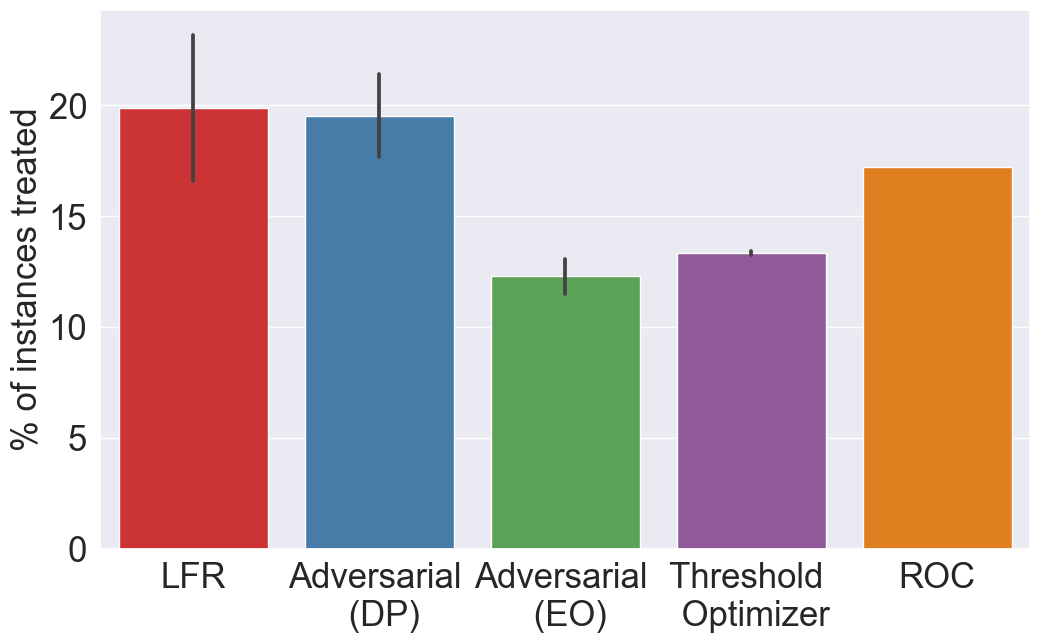

In [47]:
fig, axs = plt.subplots(1,1, figsize=(12,7))

a = sns.barplot(
    data = plot_df,
    x='method',
    y='% of predictions changed',
    errorbar='sd'
)

axs.set_xlabel('')
#axs.set_ylabel('% of predict')


axs.set_xlabel('')#, fontsize=25)
plt.xticks(fontsize=25)
#plt.legend(fontsize=25)
plt.yticks(fontsize=25)
axs.set_ylabel('% of instances treated', fontsize=25)
#axs.set_title('Methods optimizing Equalized Odds', fontsize=25)

#plt.xticks(rotation=45)
plt.savefig('../../figs/article/dutch_runs.png')
plt.savefig('../../figs/article/dutch_runs.pdf')


In [43]:
plot_df.to_csv('../../results/runs/dutch.csv')

In [50]:
plot_df.groupby('method').agg(['mean', 'std'])

% of predictions changed          
                                           mean       std
method                                                   
Adversarial \n (DP)                   19.529295  1.870385
Adversarial \n (EO)                   12.289639  0.780383
LFR                                   19.875455  3.294064
ROC                                   17.242635  0.000000
Threshold \n Optimizer                13.358491  0.085428

In [51]:
lfr_stats.describe()

,Unnamed: 0,Run,Accuracy,Balanced Accuracy,P%-rule,% of predictions changed,num of predictions changed
count,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.00000
mean,4.875000,5.875000,0.749491,0.746360,91.568345,19.875455,6004.37500
std,3.136764,3.136764,0.024801,0.025613,5.639974,3.294064,995.13688
min,0.000000,1.000000,0.708342,0.696702,85.525817,15.948361,4818.00000
25%,2.750000,3.750000,0.734964,0.738628,86.425361,17.347733,5240.75000
50%,5.000000,6.000000,0.753178,0.749397,90.968706,19.885799,6007.50000
75%,7.250000,8.250000,0.761172,0.757731,95.913080,20.993049,6342.00000
max,9.000000,10.000000,0.783317,0.778906,98.934705,25.809335,7797.00000


# Comparisons

In [35]:
comp_df = test_results.assign(
    lfr_pred = (test_results.lfr_pred>0.5).astype(int),
    adv_pred = (test_results.adv_pred>0.5).astype(int),
    biased_pred = (test_results.biased_pred>0.5).astype(int),
    target = y_test
)

In [36]:
comp_df = comp_df.assign(
    eq_change = comp_df.eq_pred - comp_df.biased_pred,
    adv_change = comp_df.adv_pred - comp_df.biased_pred,
    lfr_change = comp_df.lfr_pred - comp_df.biased_pred,
    roc_change = comp_df.roc_pred - comp_df.biased_pred,
    adveq_change = comp_df.adveq_pred - comp_df.biased_pred
)

In [37]:
comp_df.head()

,sex,biased_pred,lfr_pred,adv_pred,adveq_pred,eq_pred,roc_pred,target,eq_change,adv_change,lfr_change,roc_change,adveq_change
6235,1,0,0,0,0,0,0.0,1,0,0,0,0.0,0
49276,0,0,0,0,0,0,0.0,0,0,0,0,0.0,0
7891,0,0,0,0,0,0,0.0,0,0,0,0,0.0,0
17572,1,1,1,1,1,1,1.0,1,0,0,0,0.0,0
34628,0,0,0,1,0,0,0.0,0,0,1,0,0.0,0


In [38]:
methods = ['Biased', 'LFR', 'Adversarial', 'Reject Option', 'Adversarial (Equal Odds)', 'Equal Odds' ]
df_dict = {'method' : methods, 'Accuracy' : [], 'Balanced Accuracy' : [], 'p-rule' : []}

for a in ['biased_pred', 'lfr_pred', 'adv_pred',  'roc_pred', 'adveq_pred', 'eq_pred']:
    acc = metrics.accuracy_score(comp_df.target, comp_df[a])
    bal_acc = metrics.balanced_accuracy_score(comp_df.target, comp_df[a])
    prule = p_rule(comp_df[a], comp_df.sex)
    
    df_dict['Accuracy'].append(acc)
    df_dict['Balanced Accuracy'].append(bal_acc)
    df_dict['p-rule'].append(prule)

In [39]:
pd.DataFrame(df_dict)

,method,Accuracy,Balanced Accuracy,p-rule
0,Biased,0.830056,0.829620,45.648520
1,LFR,0.751672,0.748985,98.491631
2,Adversarial,0.703608,0.698110,95.437786
3,Reject Option,0.762099,0.753223,96.905933
4,Adversarial (Equal Odds),0.755611,0.758074,75.427701
5,Equal Odds,0.796359,0.791361,63.709185


## How many instances does each method change ?

In [40]:
comp_df.to_csv('../../results/dutch/preds_2.csv')

In [243]:
eq_changed = len(comp_df[comp_df.eq_change!=0])
adv_changed = len(comp_df[comp_df.adv_change!=0])
lfr_changed = len(comp_df[comp_df.lfr_change!=0])
roc_changed = len(comp_df[comp_df.roc_change!=0])
adveq_changed = len(comp_df[comp_df.adveq_change!=0])

eq_perc = eq_changed / len(comp_df) * 100
adv_perc = adv_changed / len(comp_df)* 100
lfr_perc = lfr_changed / len(comp_df)* 100
roc_perc = roc_changed / len(comp_df)* 100
adveq_perc = adveq_changed / len(comp_df)* 100

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'LFR'),
  Text(1, 0, 'Adversarial'),
  Text(2, 0, 'Reject Option'),
  Text(3, 0, 'Adversarial (Equal Odds)'),
  Text(4, 0, 'Equal Odds')])

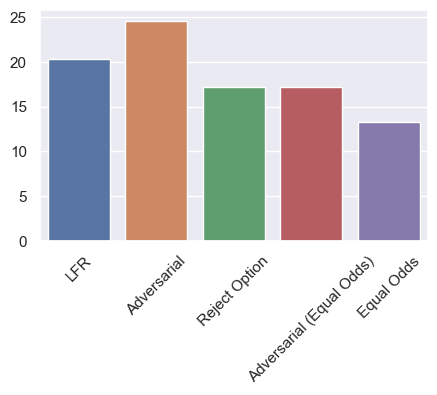

In [250]:
fig, axs = plt.subplots(1,1,figsize=(5,3))

sns.barplot(x=methods[1:], y=[lfr_perc, adv_perc, roc_perc, adveq_perc, eq_perc])
plt.xticks(rotation=45)


In [251]:
print(f'percentage of predictions changed by adversarial: {adv_perc:.2f}%')
print(f'percentage of predictions changed by lfr: {lfr_perc:.2f}%')
print(f'percentage of predictions changed by roc: {roc_perc:.2f}%')
print(f'percentage of predictions changed by adversarial (equal odds): {adveq_perc:.2f}%')
print(f'percentage of predictions changed by equal odds: {eq_perc:.2f}%')

percentage of predictions changed by adversarial: 24.59%
percentage of predictions changed by lfr: 20.36%
percentage of predictions changed by roc: 17.24%
percentage of predictions changed by adversarial (equal odds): 17.24%
percentage of predictions changed by equal odds: 13.26%


In [252]:
inters = len(comp_df[(comp_df.adv_change!=0) & (comp_df.lfr_change!=0) & (comp_df.roc_change!=0)])
union = len(comp_df[(comp_df.adv_change!=0) | (comp_df.lfr_change!=0) | (comp_df.roc_change!=0)])
inters / union * 100

18.625978338208554

## Are these the same instances ?

How many instances were changed by just one method, how many by two, and how many by three ?

<AxesSubplot:xlabel='num_changes', ylabel='perc'>

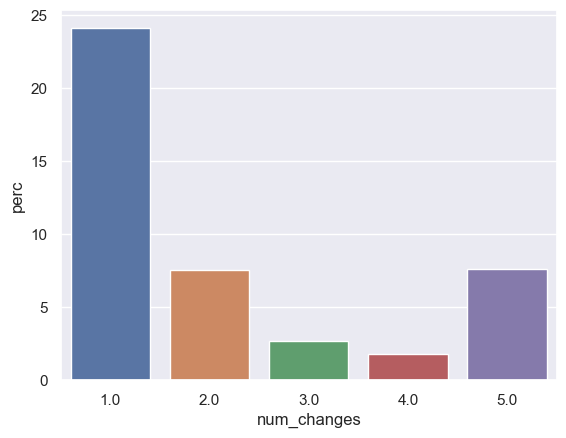

In [254]:
comp_df = comp_df.assign(
    num_changes = abs(comp_df.eq_change) + abs(comp_df.adv_change) + abs(comp_df.lfr_change) + abs(comp_df.roc_change) + abs(comp_df.adveq_change)
)

plot_df = comp_df.groupby('num_changes').count()[['sex']].reset_index().rename({'sex':'num'}, axis=1)
plot_df = plot_df[plot_df.num_changes!=0].assign(perc = round(plot_df.num / len(comp_df) * 100, 2))
sns.barplot(data=plot_df, x='num_changes', y='perc')

In [255]:
comp_df[comp_df.num_changes>=3]

,sex,biased_pred,lfr_pred,adv_pred,eq_pred,roc_pred,adveq_pred,target,eq_change,adv_change,lfr_change,roc_change,adveq_change,num_changes
31303,1,1,0,1,0,0.0,0.0,1,-1,0,-1,-1.0,-1.0,4.0
41667,1,1,0,0,0,0.0,0.0,0,-1,-1,-1,-1.0,-1.0,5.0
35787,0,0,1,1,1,0.0,0.0,0,1,1,1,0.0,0.0,3.0
24105,1,1,0,0,0,0.0,0.0,1,-1,-1,-1,-1.0,-1.0,5.0
5034,1,1,0,0,0,0.0,0.0,1,-1,-1,-1,-1.0,-1.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55768,1,1,1,0,1,0.0,0.0,1,0,-1,0,-1.0,-1.0,3.0
15116,1,1,0,0,0,0.0,0.0,1,-1,-1,-1,-1.0,-1.0,5.0
35345,1,1,0,0,0,0.0,0.0,0,-1,-1,-1,-1.0,-1.0,5.0
32047,1,1,0,1,0,0.0,0.0,0,-1,0,-1,-1.0,-1.0,4.0


In [256]:
plot_df

,num_changes,num,perc
1,1.0,7287,24.12
2,2.0,2280,7.55
3,3.0,817,2.70
4,4.0,541,1.79
5,5.0,2308,7.64


### Values achieved by each 

In [257]:
num_women = len(comp_df[comp_df.sex==0])
num_men = len(comp_df[comp_df.sex==1])

In [258]:
lfr_perc_women = len(comp_df[(comp_df.sex==0) & (comp_df.lfr_pred==1)]) / num_women * 100
lfr_perc_men = len(comp_df[(comp_df.sex==1) & (comp_df.lfr_pred==1)]) / num_men * 100

adv_perc_women = len(comp_df[(comp_df.sex==0) & (comp_df.adv_pred==1)]) / num_women * 100
adv_perc_men = len(comp_df[(comp_df.sex==1) & (comp_df.adv_pred==1)]) / num_men * 100

roc_perc_women = len(comp_df[(comp_df.sex==0) & (comp_df.roc_pred==1)]) / num_women * 100
roc_perc_men = len(comp_df[(comp_df.sex==1) & (comp_df.roc_pred==1)]) / num_men * 100

adveq_perc_women = len(comp_df[(comp_df.sex==0) & (comp_df.adveq_pred==1)]) / num_women * 100
adveq_perc_men = len(comp_df[(comp_df.sex==1) & (comp_df.adveq_pred==1)]) / num_men * 100

eq_perc_women = len(comp_df[(comp_df.sex==0) & (comp_df.eq_pred==1)]) / num_women * 100
eq_perc_men = len(comp_df[(comp_df.sex==1) & (comp_df.eq_pred==1)]) / num_men * 100

In [260]:
print('LFR:')
print(f'{lfr_perc_women:.2f}% of women classified positively')
print(f'{lfr_perc_men:.2f}% of men classified positively')
print()

print('Adversarial:')
print(f'{adv_perc_women:.2f}% of women classified positively')
print(f'{adv_perc_men:.2f}% of men classified positively')
print()

print('ROC:')
print(f'{roc_perc_women:.2f}% of women classified positively')
print(f'{roc_perc_men:.2f}% of men classified positively')
print()

print('Adversarial (Equal Odds):')
print(f'{adveq_perc_women:.2f}% of women classified positively')
print(f'{adveq_perc_men:.2f}% of men classified positively')
print()

print(f'Equal Odds:')
print(f'{eq_perc_women:.2f}% of women classified positively')
print(f'{eq_perc_men:.2f}% of men classified positively')
print()

LFR:
43.53% of women classified positively
42.87% of men classified positively

Adversarial:
38.21% of women classified positively
39.43% of men classified positively

ROC:
29.79% of women classified positively
30.74% of men classified positively

Adversarial (Equal Odds):
29.79% of women classified positively
30.74% of men classified positively

Equal Odds:
29.17% of women classified positively
46.70% of men classified positively



### Focus:

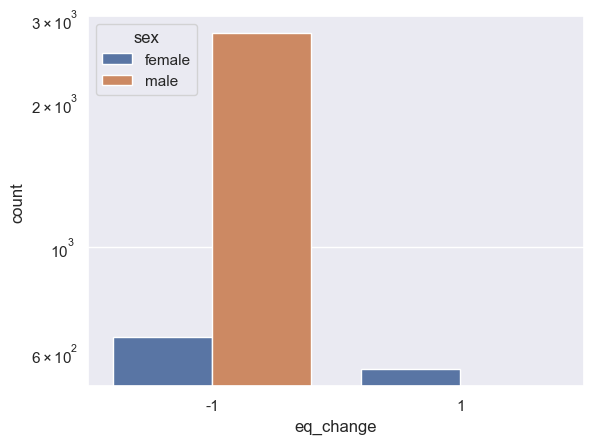

In [261]:
plt_eq = comp_df[comp_df.eq_change!=0].assign(sex = comp_df.sex.map(lambda x: 'male' if x==1 else 'female')).groupby(['sex', 'eq_change']).count()[['biased_pred']].rename({'biased_pred':'count'}, axis=1).reset_index().assign(method = 'Equal Odds')

g = sns.barplot(data=plt_eq, x='eq_change', y='count', hue='sex')
g.set_yscale('log')

In [262]:
plt_eq

,sex,eq_change,count,method
0,female,-1,649,Equal Odds
1,female,1,555,Equal Odds
2,male,-1,2801,Equal Odds


<AxesSubplot:xlabel='adv_change', ylabel='count'>

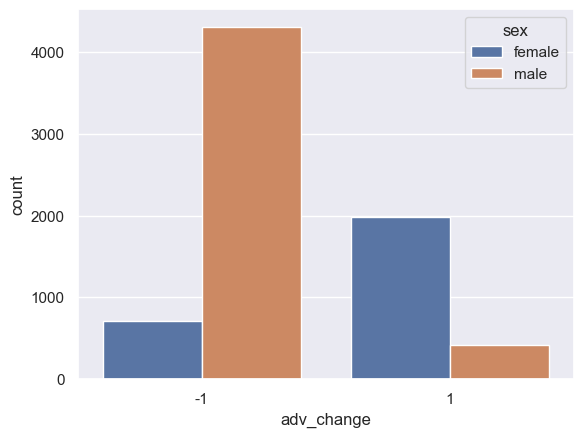

In [263]:
plt_adv = comp_df[comp_df.adv_change!=0].assign(sex = comp_df.sex.map(lambda x: 'male' if x==1 else 'female')).groupby(['sex', 'adv_change']).count()[['biased_pred']].rename({'biased_pred':'count'}, axis=1).reset_index()

sns.barplot(data=plt_adv, x='adv_change', y='count', hue='sex')

<AxesSubplot:xlabel='lfr_change', ylabel='count'>

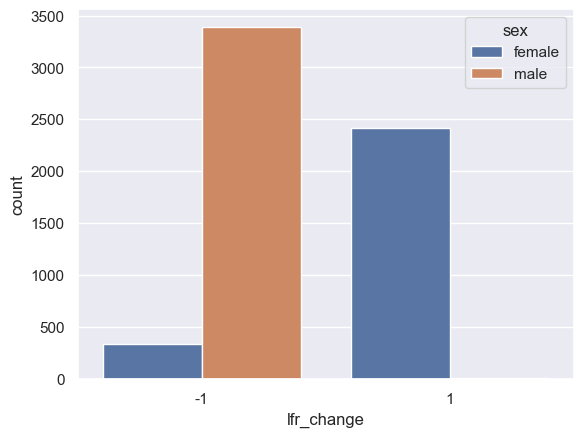

In [264]:
plt_lfr = comp_df[comp_df.lfr_change!=0].assign(sex = comp_df.sex.map(lambda x: 'male' if x==1 else 'female')).groupby(['sex', 'lfr_change']).count()[['biased_pred']].rename({'biased_pred':'count'}, axis=1).reset_index()
sns.barplot(data=plt_lfr, x='lfr_change', y='count', hue='sex')

<AxesSubplot:xlabel='roc_change', ylabel='count'>

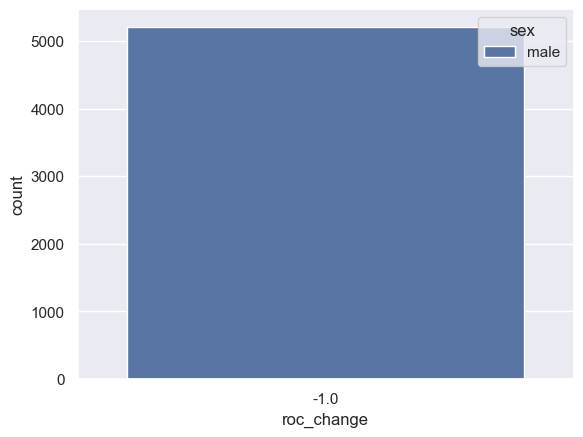

In [265]:
plt_roc = comp_df[comp_df.roc_change!=0].assign(sex = comp_df.sex.map(lambda x: 'male' if x==1 else 'female'))\
                                        .groupby(['sex', 'roc_change']).count()[['biased_pred']]\
                                        .rename({'biased_pred':'count'}, axis=1).reset_index()
sns.barplot(data=plt_roc, x='roc_change', y='count', hue='sex')

In [54]:
plt_lfr

,sex,lfr_change,count
0,female,-1,337
1,female,1,2414
2,male,-1,3389
3,male,1,10


In [55]:
plt_adv

,sex,adv_change,count
0,female,-1,747
1,female,1,1389
2,male,-1,4700
3,male,1,333


In [56]:
plt_roc

,sex,roc_change,count
0,male,-1.0,5209


In [57]:
plt_eq

,sex,eq_change,count,method
0,female,1,2426,Equal Odds
1,male,-1,3116,Equal Odds


## Are these the same people ?

In [269]:
# DP
changed_union = comp_df[(comp_df.adv_change!=0) | (comp_df.lfr_change!=0) | (comp_df.roc_change!=0)]
changed_intersect = comp_df[(comp_df.adv_change!=0) & (comp_df.lfr_change!=0) & (comp_df.roc_change!=0)]

perc_intersect = len(changed_intersect) / len(changed_union) * 100

print('Demographic Parity:')
print(f'Of all the predictions changed by at least one method, {perc_intersect:.2f}% were changed by all three')

# EO
changed_union = comp_df[(comp_df.adveq_change!=0) | (comp_df.eq_change!=0)]
changed_intersect = comp_df[(comp_df.adveq_change!=0) & (comp_df.eq_change!=0)]

perc_intersect = len(changed_intersect) / len(changed_union) * 100

print('Equal Odds:')
print(f'Of all the predictions changed by at least one method, {perc_intersect:.2f}% were changed by both')

# All
changed_union = comp_df[(comp_df.adv_change!=0) | (comp_df.lfr_change!=0) | (comp_df.roc_change!=0) | (comp_df.adveq_change!=0) | (comp_df.eq_change!=0)]
changed_intersect = comp_df[(comp_df.adv_change!=0) & (comp_df.lfr_change!=0) & (comp_df.roc_change!=0) & (comp_df.adveq_change!=0) & (comp_df.eq_change!=0)]

perc_intersect = len(changed_intersect) / len(changed_union) * 100

print('All methods:')
print(f'Of all the predictions changed by at least one method, {perc_intersect:.2f}% were changed by all five')


Demographic Parity:
Of all the predictions changed by at least one method, 18.63% were changed by all three
Equal Odds:
Of all the predictions changed by at least one method, 43.68% were changed by both
All methods:
Of all the predictions changed by at least one method, 17.44% were changed by all five


In [270]:
comp_df.to_csv('../../results/dutch/test_results.csv')

## t-sne

In [271]:
comp_df.head()

,sex,biased_pred,lfr_pred,adv_pred,eq_pred,roc_pred,adveq_pred,target,eq_change,adv_change,lfr_change,roc_change,adveq_change,num_changes
6235,1,0,0,0,0,0.0,0.0,1,0,0,0,0.0,0.0,0.0
49276,0,0,0,0,0,0.0,0.0,0,0,0,0,0.0,0.0,0.0
7891,0,0,0,0,0,0.0,0.0,0,0,0,0,0.0,0.0,0.0
17572,1,1,1,1,1,1.0,1.0,1,0,0,0,0.0,0.0,0.0
34628,0,0,0,1,0,0.0,0.0,0,0,1,0,0.0,0.0,1.0


In [272]:
a_df = comp_df[comp_df.adv_change!=0]
l_df = comp_df[comp_df.lfr_change!=0]
e_df = comp_df[comp_df.eq_change!=0]
r_df = comp_df[comp_df.roc_change!=0]
ae_df = comp_df[comp_df.adveq_change!=0]

In [273]:
from sklearn.manifold import TSNE

tsne_df = TSNE(n_components=2, learning_rate='auto',
                   init='random', perplexity=(50)).fit_transform(X_test)


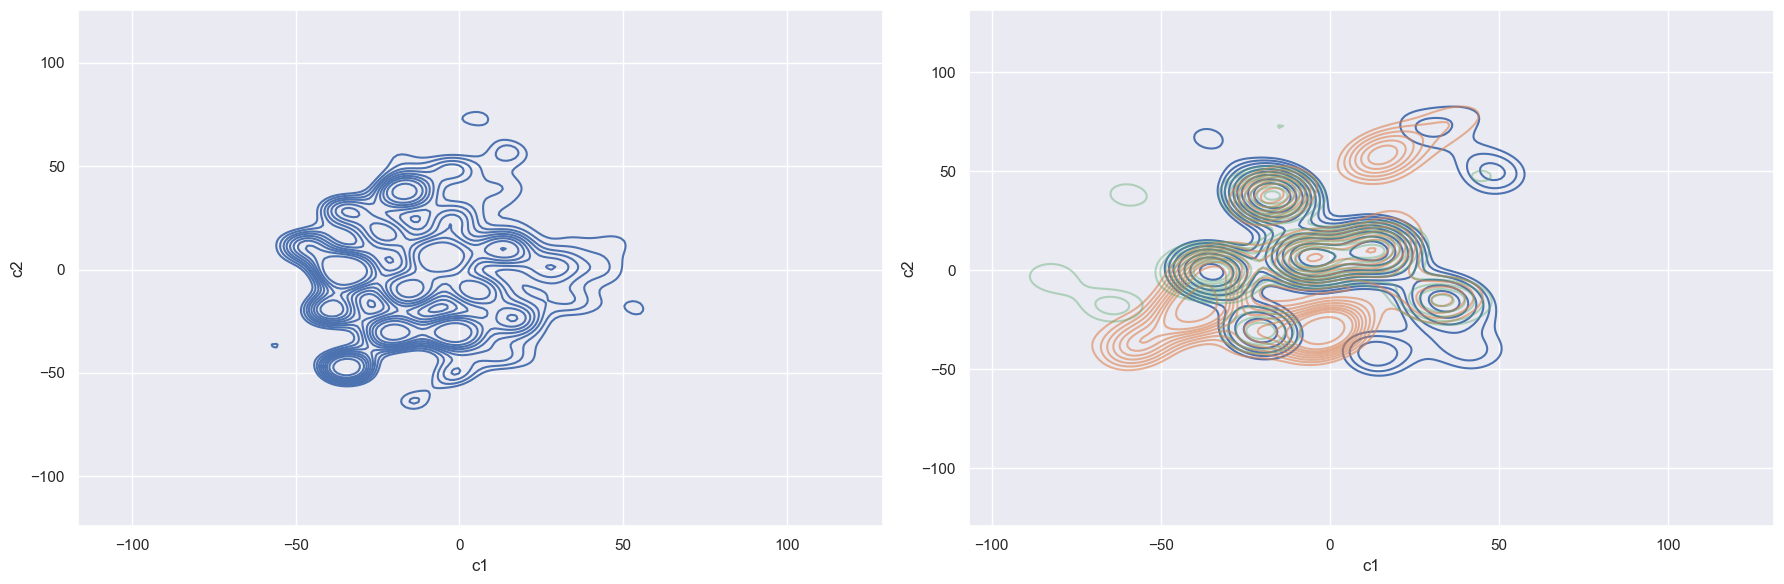

In [65]:
all_df = X_test.assign(c1 = tsne_df[:,0],
             c2 = tsne_df[:,1])

plot_a = all_df.loc[a_df.index]
plot_l = all_df.loc[l_df.index]
plot_e = all_df.loc[e_df.index]
plot_r = all_df.loc[r_df.index]
plot_x = all_df#.loc[same_df.index]

fig, axs = plt.subplots(1,2, figsize=(18,6))#, sharex=True, sharey=True)

sns.kdeplot(data=plot_x, x='c1', y='c2', ax=axs[0], label='All Instances', fill=False, thresh=0.5)
sns.kdeplot(data=plot_e, x='c1', y='c2', ax=axs[1] , label='Equal Odds', fill=False, thresh=0.3)
sns.kdeplot(data=plot_a, x='c1', y='c2', ax=axs[1] , label='Adversarial', fill=False, alpha=0.6, thresh=0.3)
sns.kdeplot(data=plot_l, x='c1', y='c2', ax=axs[1] , label='LFR', fill=False, alpha=0.4, thresh=0.3)
sns.kdeplot(data=plot_r, x='c1', y='c2', ax=axs[1] , label='ROC', fill=False, alpha=0.4, thresh=0.3)

plt.tight_layout()

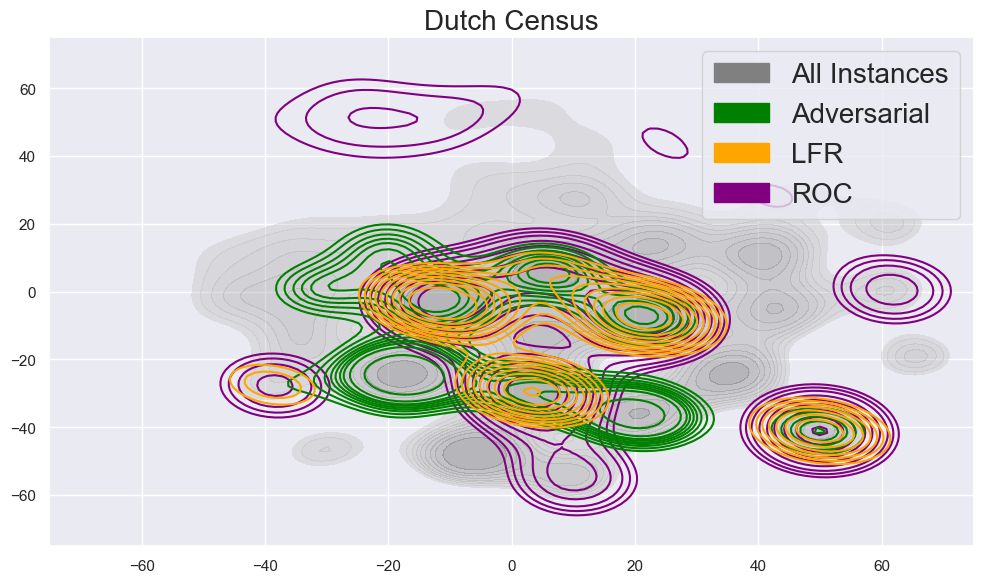

In [275]:
all_df = X_test.assign(c1 = tsne_df[:,0],
             c2 = tsne_df[:,1])

plot_a = all_df.loc[a_df.index]
plot_l = all_df.loc[l_df.index]
plot_e = all_df.loc[e_df.index]
plot_r = all_df.loc[r_df.index]
plot_ae = all_df.loc[ae_df.index]
plot_x = all_df#.loc[same_df.index]

fig, axs = plt.subplots(1,1, figsize=(10,6))#, sharex=True, sharey=True)

sns.kdeplot(data=plot_x, x='c1', y='c2', ax=axs, label='All Instances', fill=True, 
            thresh=0.5, alpha=0.4, legend=True, color='Grey')

patch_all = mpatches.Patch(
    color='Grey', label='All Instances'
)

sns.kdeplot(data=plot_r, x='c1', y='c2', ax=axs, label='ROC', fill=False, thresh=0.5, color='Purple')
patch_roc = mpatches.Patch(
    color='Purple', label='ROC'
)

#sns.kdeplot(data=plot_e, x='c1', y='c2', ax=axs, label='Equal Odds', fill=False, thresh=0.5, color='Blue')
#patch_eq = mpatches.Patch(
#    color='Blue', label='Equal Odds'
#)

sns.kdeplot(data=plot_a, x='c1', y='c2', ax=axs, label='Adversarial', fill=False, thresh=0.5, color='Green')
patch_adv = mpatches.Patch(
    color='Green', label='Adversarial'
)

sns.kdeplot(data=plot_l, x='c1', y='c2', ax=axs, label='LFR', fill=False, thresh=0.5, color='Orange')
patch_lfr = mpatches.Patch(
    color='Orange', label='LFR'
)

#sns.kdeplot(data=plot_ae, x='c1', y='c2', ax=axs, label='Adversarial (Equal Odds)', fill=False, thresh=.5, color='Orange')
#patch_ae = mpatches.Patch(
#    color='Orange', label='Adversarial (Equal Odds)'
#)

label_patches = [patch_all, patch_adv, patch_lfr, patch_roc]
#label_patches = [patch_all, patch_adv, patch_lfr, patch_roc]


axs.legend(handles=label_patches, fontsize=20)

axs.set_title('Dutch Census', fontsize=20)
axs.set_xlabel('')
axs.set_ylabel('')

plt.xlim((-75, 75))
plt.ylim((-75, 75))

#plt.savefig('../figs/dutch/tsne_all.pdf')
#plt.savefig('../figs/dutch/tsne_all.png')
plt.tight_layout()

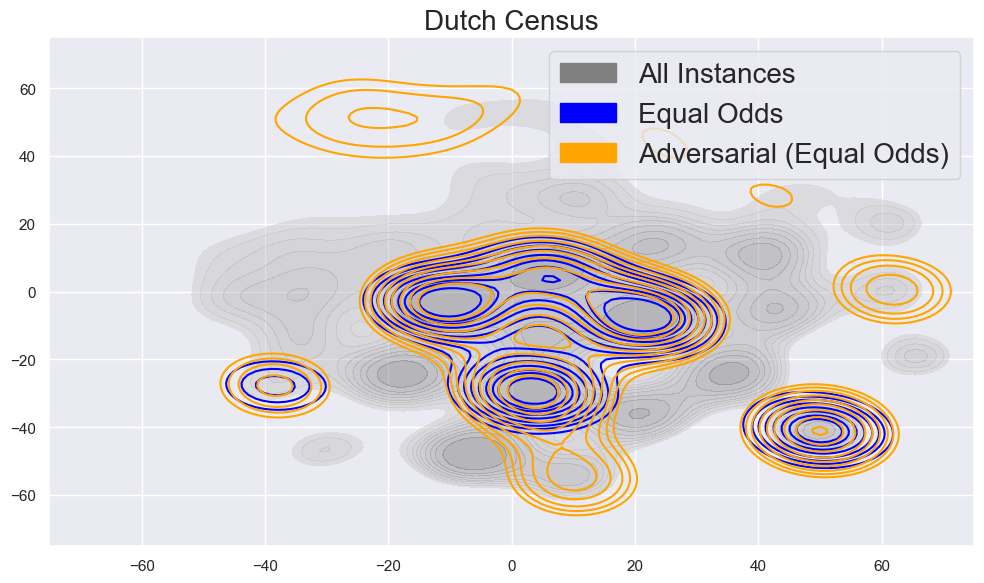

In [276]:
all_df = X_test.assign(c1 = tsne_df[:,0],
             c2 = tsne_df[:,1])

plot_a = all_df.loc[a_df.index]
plot_l = all_df.loc[l_df.index]
plot_e = all_df.loc[e_df.index]
plot_r = all_df.loc[r_df.index]
plot_ae = all_df.loc[ae_df.index]
plot_x = all_df#.loc[same_df.index]

fig, axs = plt.subplots(1,1, figsize=(10,6))#, sharex=True, sharey=True)

sns.kdeplot(data=plot_x, x='c1', y='c2', ax=axs, label='All Instances', fill=True, 
            thresh=0.5, alpha=0.4, legend=True, color='Grey')

patch_all = mpatches.Patch(
    color='Grey', label='All Instances'
)

#sns.kdeplot(data=plot_r, x='c1', y='c2', ax=axs, label='ROC', fill=False, thresh=0.5, color='Purple')
#patch_roc = mpatches.Patch(
#    color='Purple', label='ROC'
#)

sns.kdeplot(data=plot_e, x='c1', y='c2', ax=axs, label='Equal Odds', fill=False, thresh=0.5, color='Blue')
patch_eq = mpatches.Patch(
    color='Blue', label='Equal Odds'
)

#sns.kdeplot(data=plot_a, x='c1', y='c2', ax=axs, label='Adversarial', fill=False, thresh=0.5, color='Green')
#patch_adv = mpatches.Patch(
#    color='Green', label='Adversarial'
#)

#sns.kdeplot(data=plot_l, x='c1', y='c2', ax=axs, label='LFR', fill=False, thresh=0.5, color='Orange')
#patch_lfr = mpatches.Patch(
#    color='Orange', label='LFR'
#)

sns.kdeplot(data=plot_ae, x='c1', y='c2', ax=axs, label='Adversarial (Equal Odds)', fill=False, thresh=.5, color='Orange')
patch_ae = mpatches.Patch(
    color='Orange', label='Adversarial (Equal Odds)'
)

label_patches = [patch_all, patch_eq, patch_ae]
#label_patches = [patch_all, patch_adv, patch_lfr, patch_roc]


axs.legend(handles=label_patches, fontsize=20)

axs.set_title('Dutch Census', fontsize=20)
axs.set_xlabel('')
axs.set_ylabel('')

plt.xlim((-75, 75))
plt.ylim((-75, 75))

#plt.savefig('../figs/dutch/tsne_all.pdf')
#plt.savefig('../figs/dutch/tsne_all.png')
plt.tight_layout()

**fit t-sne just on changed data**

In [70]:
comp_df.head()

,sex,biased_pred,lfr_pred,adv_pred,eq_pred,roc_pred,target,eq_change,adv_change,lfr_change,roc_change,num_changes
6235,1,0,0,0,0,0.0,1,0,0,0,0.0,0.0
49276,0,0,0,0,0,0.0,0,0,0,0,0.0,0.0
7891,0,0,0,0,0,0.0,0,0,0,0,0.0,0.0
17572,1,1,1,1,1,1.0,1,0,0,0,0.0,0.0
34628,0,0,0,0,0,0.0,0,0,0,0,0.0,0.0


In [71]:
from sklearn.manifold import TSNE

tsne_df = TSNE(n_components=2, learning_rate='auto',
                   init='random', perplexity=(50)).fit_transform(X_test.loc[comp_df[comp_df.num_changes>0].index])


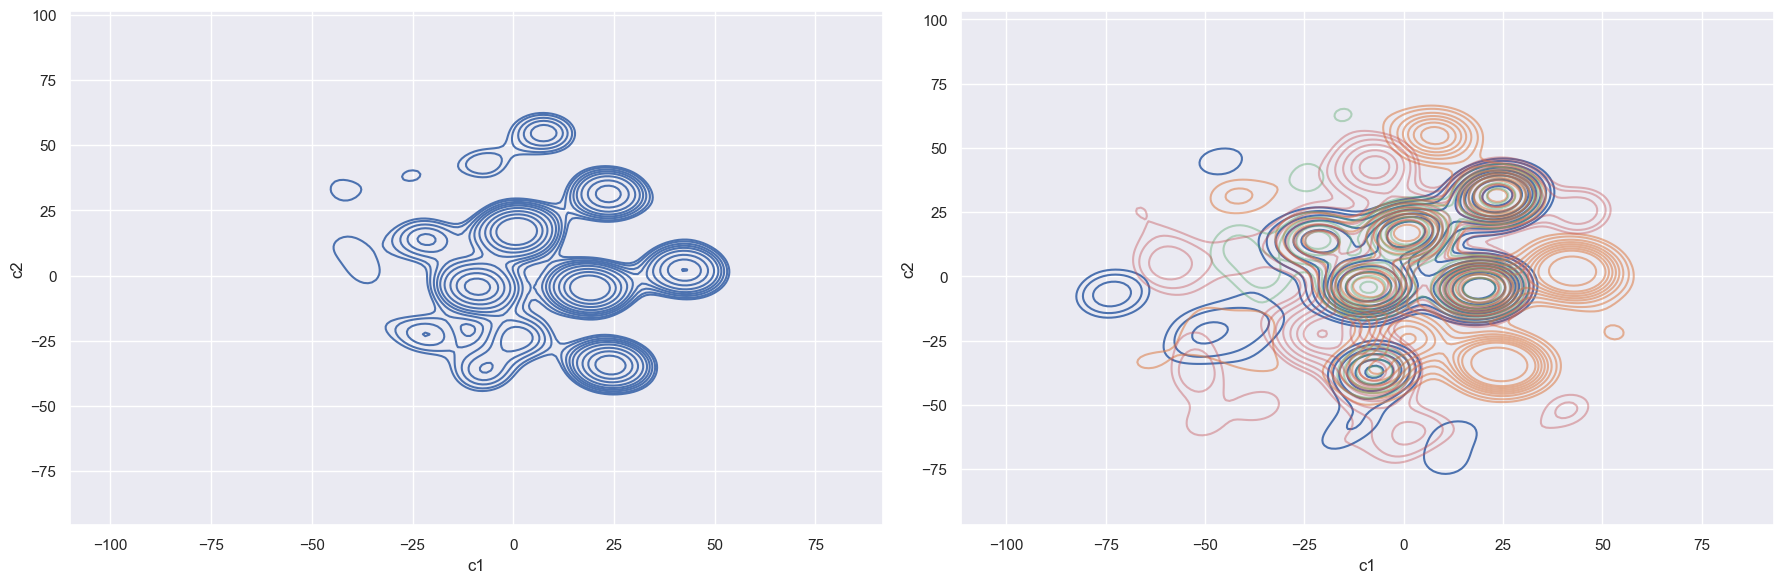

In [72]:
all_df = X_test.loc[comp_df[comp_df.num_changes>0].index].assign(c1 = tsne_df[:,0],
             c2 = tsne_df[:,1])

plot_a = all_df.loc[a_df.index]
plot_l = all_df.loc[l_df.index]
plot_e = all_df.loc[e_df.index]
plot_r = all_df.loc[r_df.index]
plot_x = all_df#.loc[same_df.index]

fig, axs = plt.subplots(1,2, figsize=(18,6))#, sharex=True, sharey=True)

sns.kdeplot(data=plot_x, x='c1', y='c2', ax=axs[0], label='All Instances', fill=False, thresh=0.5)
sns.kdeplot(data=plot_e, x='c1', y='c2', ax=axs[1] , label='Equal Odds', fill=False, thresh=0.3)
sns.kdeplot(data=plot_a, x='c1', y='c2', ax=axs[1] , label='Adversarial', fill=False, alpha=0.6, thresh=0.3)
sns.kdeplot(data=plot_l, x='c1', y='c2', ax=axs[1] , label='LFR', fill=False, alpha=0.4, thresh=0.3)
sns.kdeplot(data=plot_r, x='c1', y='c2', ax=axs[1] , label='ROC', fill=False, alpha=0.4, thresh=0.3)

plt.tight_layout()

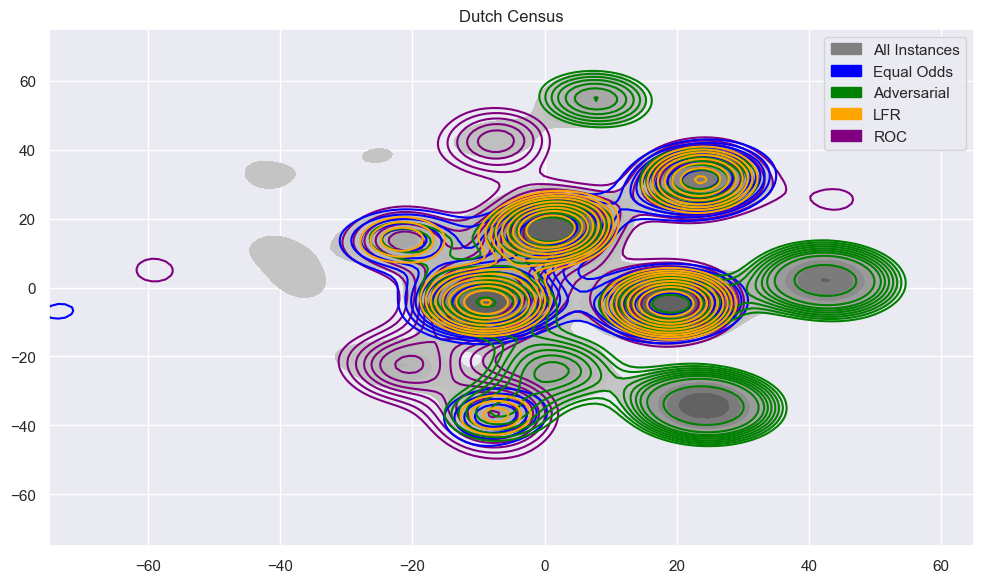

In [76]:
all_df = X_test.loc[comp_df[comp_df.num_changes>0].index].assign(c1 = tsne_df[:,0],
             c2 = tsne_df[:,1])

plot_a = all_df.loc[a_df.index]
plot_l = all_df.loc[l_df.index]
plot_e = all_df.loc[e_df.index]
plot_r = all_df.loc[r_df.index]
plot_x = all_df#.loc[same_df.index]

fig, axs = plt.subplots(1,1, figsize=(10,6))#, sharex=True, sharey=True)

sns.kdeplot(data=plot_x, x='c1', y='c2', ax=axs, label='All Instances', fill=True, 
            thresh=0.5, legend=True, color='Grey')

patch_all = mpatches.Patch(
    color='Grey', label='All Instances'
)

sns.kdeplot(data=plot_r, x='c1', y='c2', ax=axs, label='ROC', fill=False, thresh=0.5, color='Purple')
patch_roc = mpatches.Patch(
    color='Purple', label='ROC'
)

sns.kdeplot(data=plot_e, x='c1', y='c2', ax=axs, label='Equal Odds', fill=False, thresh=0.5, color='Blue')
patch_eq = mpatches.Patch(
    color='Blue', label='Equal Odds'
)

sns.kdeplot(data=plot_a, x='c1', y='c2', ax=axs, label='Adversarial', fill=False, thresh=0.5, color='Green')
patch_adv = mpatches.Patch(
    color='Green', label='Adversarial'
)

sns.kdeplot(data=plot_l, x='c1', y='c2', ax=axs, label='LFR', fill=False, thresh=0.5, color='Orange')
patch_lfr = mpatches.Patch(
    color='Orange', label='LFR'
)

label_patches = [patch_all, patch_eq, patch_adv, patch_lfr, patch_roc]
#label_patches = [patch_all, patch_adv, patch_lfr, patch_roc]


axs.legend(handles=label_patches)

axs.set_title('Dutch Census')
axs.set_xlabel('')
axs.set_ylabel('')

plt.xlim((-75, 65))
plt.ylim((-75, 75))

#plt.savefig('../figs/dutch/tsne_all.pdf')
#plt.savefig('../figs/dutch/tsne_all.png')
plt.tight_layout()

## Umap

In [77]:
import umap

ModuleNotFoundError: No module named 'umap'

In [78]:
reducer = umap.UMAP()

NameError: name 'umap' is not defined

In [85]:
embedding = reducer.fit_transform(X_test)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/B429DU/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:374: UserWarning: Exited at iteration 2000 with accuracies 
[3.46931676e-15 1.39882317e-06 5.03002696e-06 3.21696754e-05]
not reaching the requested tolerance 1e-05.
  _, diffusion_map = lobpcg(


In [87]:
umap_df = pd.DataFrame(embedding, columns=['c1', 'c2'], index=X_test.index)
umap_df.head()

,c1,c2
6235,9.295228,-11.633606
49276,26.890518,13.282517
7891,-0.903641,18.670141
17572,17.768934,3.121022
34628,-7.635658,-3.282934


<AxesSubplot: xlabel='c1', ylabel='c2'>

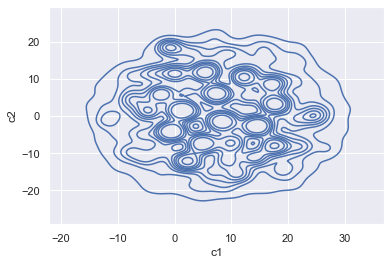

In [88]:
sns.kdeplot(umap_df, x='c1', y='c2')

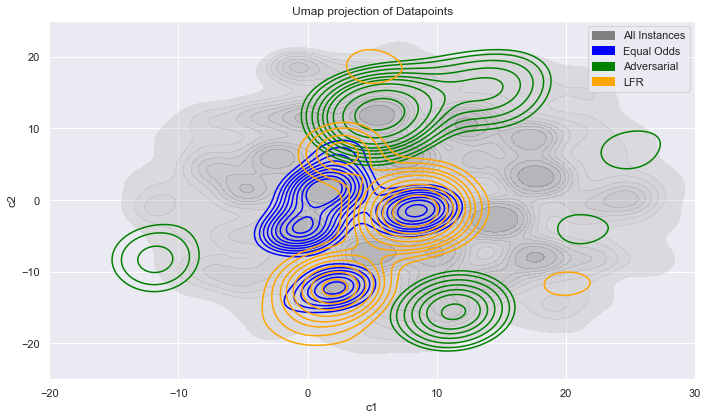

In [315]:
all_df = umap_df#X_test.assign(c1 = umap_df[:,0],
             #c2 = umap_df[:,1])

plot_a = all_df.loc[a_df.index]
plot_l = all_df.loc[l_df.index]
plot_e = all_df.loc[e_df.index]
plot_x = all_df#.loc[same_df.index]

fig, axs = plt.subplots(1,1, figsize=(10,6))#, sharex=True, sharey=True)

sns.kdeplot(data=plot_x, x='c1', y='c2', ax=axs, label='All Instances', fill=True, 
            thresh=0.1, alpha=0.4, legend=True, color='Grey')

patch_all = mpatches.Patch(
    color='Grey', label='All Instances'
)

sns.kdeplot(data=plot_e, x='c1', y='c2', ax=axs, label='Equal Odds', fill=False, thresh=0.4, color='Blue')#, cut=0.3)
patch_eq = mpatches.Patch(
    color='Blue', label='Equal Odds'
)

sns.kdeplot(data=plot_a, x='c1', y='c2', ax=axs, label='Adversarial', fill=False, thresh=0.4, color='Green')#, cut=0.3)
patch_adv = mpatches.Patch(
    color='Green', label='Adversarial'
)

sns.kdeplot(data=plot_l, x='c1', y='c2', ax=axs, label='LFR', fill=False, thresh=0.4, color='Orange')#, cut=0.3)
patch_lfr = mpatches.Patch(
    color='Orange', label='LFR'
)

label_patches = [patch_all, patch_eq, patch_adv, patch_lfr]


axs.legend(handles=label_patches)

axs.set_title('Umap projection of Datapoints')

plt.xlim((-20,30))
plt.ylim((-25,25))

plt.savefig('../figs/dutch/umap_all.pdf')
plt.savefig('../figs/dutch/umap_all.png')

plt.tight_layout()

# DIG sampling + Decision Tree

In [92]:
import discrepancies as disc
from discrepancies import pool
from discrepancies import DIG

In [186]:
class LFR_model:
    
    def __init__(self, lfr, model):
        self.lfr = lfr
        self.model = model
        
    def fit(self):
        pass
    
    def predict(self, XZ):
        
        bld = BinaryLabelDataset(df = XZ.assign(occupation_high_level = 0),
                                label_names=['occupation_high_level'],
                                protected_attribute_names=['sex'])
        df = self.lfr.transform(bld).convert_to_dataframe()[0].drop(columns=['sex', 'occupation_high_level'])
        
        return self.model.predict(torch.Tensor(df.to_numpy()))
    
class EQ_model:
    
    def __init__(self, model):
        self.model = model
        
    def fit(self):
        pass
    
    def predict(self, XZ):
        return self.model.predict(X=torch.Tensor(XZ.drop(columns=['sex']).to_numpy()),
                                  sensitive_features=torch.Tensor(XZ['sex'].to_numpy()))
    
class Simple_Model:
    
    def __init__(self, model):
        self.model = model
        
    def fit(self):
        pass
    
    def predict(self, XZ):
        return (self.model.predict(torch.Tensor(XZ.drop(columns=['sex']).to_numpy()))>0.5).astype(int)

In [187]:
lfr_wrap = LFR_model(lfr, lfr_clf)
eq_wrap = EQ_model(m)
adv_wrap = Simple_Model(adfl_)
biased_wrap = Simple_Model(biased_clf)

In [188]:
eq_pool = pool.FairnessPool([eq_wrap, biased_wrap], ['Equal Odds', 'Biased'], 'sex')
adv_pool = pool.FairnessPool([adv_wrap, biased_wrap], ['Adversarial', 'Biased'], 'sex')
lfr_pool = pool.FairnessPool([lfr_wrap, biased_wrap], ['LFR', 'Biased'], 'sex')

In [189]:
check = lfr_pool.predict(XZ=X_test.join(Z_test))
check = check.assign(
    Biased = (check.Biased>0.5).astype(int),
    sex=Z_test,
    target=y_test,
    LFR = (check.LFR>0.5).astype(int)
)

In [190]:
print(p_rule(check['LFR'], check.sex))
print(metrics.accuracy_score(check.target, check['LFR'])*100)
print(metrics.balanced_accuracy_score(check.target, check['LFR'])*100)

85.88032168836781
78.37140019860973
77.97714771565829


In [191]:
sample = X_test.join(Z_test).sample(250)#.assign(occupation_high_level=0)

In [195]:
dd = adv_pool.predict_discrepancies(sample)
dd.head()

,Adversarial,Biased,discrepancies
30420,0,0,0
53894,0,0,0
5414,1,1,0
23560,1,1,0
44438,0,0,0


In [196]:
X_test.head(1)

,age,prev_residence_place,edu_level,Marital_status,moved_recently,citizenship_europe,citizenship_netherlands,citizenship_rest_of_world,country_birth_europe,country_birth_netherlands,country_birth_rest_of_world,economic_status_111,economic_status_112,economic_status_120,marital_status_divorced,marital_status_married,marital_status_single,marital_status_widowed
6235,1.16054,-0.15703,-0.972347,0.270881,-0.15703,-0.11686,0.141013,-0.077852,-0.162263,0.280256,-0.222497,0.417491,-0.274791,-0.291301,-0.250593,0.802157,-0.692149,-0.09281


In [197]:
X_test.columns

Index(['age', 'prev_residence_place', 'edu_level', 'Marital_status',
       'moved_recently', 'citizenship_europe', 'citizenship_netherlands',
       'citizenship_rest_of_world', 'country_birth_europe',
       'country_birth_netherlands', 'country_birth_rest_of_world',
       'economic_status_111', 'economic_status_112', 'economic_status_120',
       'marital_status_divorced', 'marital_status_married',
       'marital_status_single', 'marital_status_widowed'],
      dtype='object')

In [202]:
digger = DIG.Digger(
    sample,#.drop(columns=['occupation_high_level']),
    y_test,#sample.occupation_high_level,
    eq_pool,
    categorical_names=['Marital_status',
       'moved_recently', 'citizenship_europe', 'citizenship_netherlands',
       'citizenship_rest_of_world', 'country_birth_europe',
       'country_birth_netherlands', 'country_birth_rest_of_world',
       'economic_status_111', 'economic_status_112', 'economic_status_120',
       'marital_status_divorced', 'marital_status_married',
       'marital_status_single', 'marital_status_widowed']
).fit(max_epochs=7)

INFO:root:### EPOCH #1
INFO:root:### EPOCH #2


epoch 1
(82, 19)
epoch 2
(1039, 19)


INFO:root:### EPOCH #3


epoch 3
(2400, 19)


INFO:root:### EPOCH #4


epoch 4
(3274, 19)


INFO:root:### EPOCH #5


epoch 5
(4859, 19)


INFO:root:### EPOCH #6


epoch 6
(7803, 19)


INFO:root:### EPOCH #7


epoch 7
(13928, 19)


In [206]:
nodes = pd.concat(
    [digger.get_nodes_attributes(digger.get_nodes())[0],
    digger.get_nodes_attributes(digger.get_nodes())[1]],
    axis=1
).assign(
    discrepancy = lambda x: (x['Equal Odds']!=x['Biased']).astype(int)
)

In [207]:
nodes.head()

,age,prev_residence_place,edu_level,Marital_status,moved_recently,citizenship_europe,citizenship_netherlands,citizenship_rest_of_world,country_birth_europe,country_birth_netherlands,...,economic_status_112,economic_status_120,marital_status_divorced,marital_status_married,marital_status_single,marital_status_widowed,sex,Equal Odds,Biased,discrepancy
30420,-1.824153,-0.15703,-1.737869,-1.102851,-0.15703,-0.11686,0.141013,-0.077852,-0.162263,0.280256,...,3.639132,-0.291301,-0.250593,-1.246639,1.444776,-0.09281,1.0,0,0,0
53894,-0.544999,-0.15703,-0.206825,0.270881,-0.15703,-0.11686,0.141013,-0.077852,-0.162263,0.280256,...,-0.274791,-0.291301,-0.250593,0.802157,-0.692149,-0.09281,0.0,0,0,0
5414,0.307770,-0.15703,-0.206825,0.270881,-0.15703,-0.11686,0.141013,-0.077852,-0.162263,0.280256,...,-0.274791,3.432870,-0.250593,0.802157,-0.692149,-0.09281,0.0,1,1,0
23560,0.307770,-0.15703,1.324218,0.270881,-0.15703,-0.11686,0.141013,-0.077852,-0.162263,0.280256,...,-0.274791,-0.291301,-0.250593,0.802157,-0.692149,-0.09281,0.0,1,1,0
44438,-0.971383,-0.15703,-0.972347,-1.102851,-0.15703,-0.11686,0.141013,-0.077852,-0.162263,0.280256,...,-0.274791,-0.291301,-0.250593,-1.246639,1.444776,-0.09281,1.0,0,0,0


In [310]:
#(X_train, X_test, y_train, y_test, Z_train, Z_test) = split_scale_pipe(pd.get_dummies(data.drop(columns=['sex', 'occupation_high_level'])),
#                                                                      data.occupation_high_level,
#                                                                      (data.sex=='male').astype(int),
#                                                                      stratify=data.occupation_high_level)

X = pd.get_dummies(data.drop(columns=['sex', 'occupation_high_level', 'marital_status']))
y = data.occupation_high_level
Z = (data.sex=='male').astype(int)

In [313]:
X.head()

,age,prev_residence_place,edu_level,Marital_status,moved_recently,citizenship_europe,citizenship_netherlands,citizenship_rest_of_world,country_birth_europe,country_birth_netherlands,country_birth_rest_of_world,economic_status_111,economic_status_112,economic_status_120
0,6,1,5,1,0,0,1,0,0,1,0,1,0,0
1,10,1,2,2,0,0,1,0,0,1,0,1,0,0
2,8,1,2,2,0,0,1,0,0,1,0,1,0,0
3,12,1,1,2,0,0,1,0,0,1,0,1,0,0
4,4,1,2,1,0,0,1,0,0,1,0,1,0,0


In [231]:
(trainx, testx, trainy, testy,
     trainz, testz) = train_test_split(X, y, Z, test_size=0.5,
                                         stratify=y, random_state=11)

scaler = StandardScaler().fit(trainx)

nodes_unscaled = pd.DataFrame(scaler.inverse_transform(nodes[~nodes.index.isin(X.index)][X_test.columns]), columns=X_test.columns,
            index=nodes.index[~nodes.index.isin(X.index)])
nodes_unscaled.head()

,age,prev_residence_place,edu_level,Marital_status,moved_recently,citizenship_europe,citizenship_netherlands,citizenship_rest_of_world,country_birth_europe,country_birth_netherlands,country_birth_rest_of_world,economic_status_111,economic_status_112,economic_status_120,marital_status_divorced,marital_status_married,marital_status_single,marital_status_widowed
60420,5.0,1.0,3.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
60421,5.0,1.0,3.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
60422,5.0,1.0,3.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
60423,5.0,1.0,3.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
60424,5.0,1.0,3.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [250]:
df = pd.concat([nodes_unscaled, X.loc[~X.index.isin(nodes_unscaled.index) & X.index.isin(nodes.index)]])\
    .join(nodes[['Equal Odds', 'Biased', 'discrepancy']])

df.head()

,age,prev_residence_place,edu_level,Marital_status,moved_recently,citizenship_europe,citizenship_netherlands,citizenship_rest_of_world,country_birth_europe,country_birth_netherlands,...,economic_status_111,economic_status_112,economic_status_120,marital_status_divorced,marital_status_married,marital_status_single,marital_status_widowed,Equal Odds,Biased,discrepancy
60420,5.0,1.0,3.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0
60421,5.0,1.0,3.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0
60422,5.0,1.0,3.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0
60423,5.0,1.0,3.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0
60424,5.0,1.0,3.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0


In [252]:
x_tree_train, x_tree_test, y_tree_train, y_tree_test = train_test_split(df.drop(columns=['Equal Odds', 'Biased', 'discrepancy']),
                                                                       df[['discrepancy']],
                                                                       test_size=0.5, stratify=df[['discrepancy']], random_state=11)

In [288]:
from sklearn.tree import DecisionTreeClassifier

dec_tree = DecisionTreeClassifier(max_depth=5)
dec_tree = dec_tree.fit(x_tree_train,
                       y_tree_train)

In [289]:
preds = dec_tree.predict(x_tree_test)
metrics.balanced_accuracy_score(y_tree_test, preds)

0.6099550533029375

In [290]:
import graphviz
from sklearn import tree

In [291]:
dot_data = tree.export_graphviz(dec_tree, out_file=None, feature_names=list(X_test.columns), class_names=['not changed', 'changed'])
graph = graphviz.Source(dot_data)

In [292]:
graph.render('dutch_eq')

'dutch_eq.pdf'

In [304]:
x_tree_train, x_tree_test, y_tree_train, y_tree_test = train_test_split(dff.drop(columns=['Equal Odds', 'Biased', 'discrepancy']),
                                                                       dff[['discrepancy']],
                                                                       test_size=0.5, stratify=dff[['discrepancy']], random_state=11)
scaler = StandardScaler().fit(x_tree_train)
scale_df = lambda df, scaler: pd.DataFrame(scaler.transform(df), 
                                               columns=df.columns, index=df.index)
x_train = x_tree_train.pipe(scale_df, scaler)
x_test = x_tree_test.pipe(scale_df, scaler)

In [307]:
from sklearn.tree import DecisionTreeClassifier

dec_tree = DecisionTreeClassifier(max_depth=5)
dec_tree = dec_tree.fit(x_train,
                       y_tree_train)

In [308]:
preds = dec_tree.predict(x_tree_test)
metrics.balanced_accuracy_score(y_tree_test, preds)

0.4990382781085771

In [294]:
df.columns

Index(['age', 'prev_residence_place', 'edu_level', 'Marital_status',
       'moved_recently', 'citizenship_europe', 'citizenship_netherlands',
       'citizenship_rest_of_world', 'country_birth_europe',
       'country_birth_netherlands', 'country_birth_rest_of_world',
       'economic_status_111', 'economic_status_112', 'economic_status_120',
       'marital_status_divorced', 'marital_status_married',
       'marital_status_single', 'marital_status_widowed', 'Equal Odds',
       'Biased', 'discrepancy'],
      dtype='object')